# Within Top 10% with Simple Regression Model.
[vjgupta](https://www.kaggle.com/vjgupta/reach-top-10-with-simple-model-on-housing-prices) を翻訳

# 住宅価格を予測するための着実な手順

# パッケージをインポートする
**numpy** と **pandas** でデータと数値を取り扱いましょう。そして、**seaborn** と **matplotlib** でデータを可視化しましょう。
不要な Warning は切ってしまいましょう。
**Scipy** は正規化と、歪度の計算に使います。

In [1]:
#必要なライブラリのインポート

import numpy as np  # 線形代数
import pandas as pd  # データの前処理やファイルの読み書き(e.g. pd.read_csv)
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn  # うるさい warning をシャットアウトする(sklearn と seabornからやってくる)

from scipy import stats
from scipy.stats import norm, skew  # 大事な統計計算

# データをロードして眺めてみる

Pandas の豊富な関数を使って、トレーニングデータとテストデータをまとめて眺めて、何をすべきか考えてみましょう。
これから取り扱うのは巨大なデータセットです。

In [2]:
# まずはトレーニングデータとテストデータを pandas dataframe に読み込んでみましょう
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
print ("Size of train data : {}" .format(train.shape))

print ("Size of test data : {}" .format(test.shape))

Size of train data : (1460, 81)
Size of test data : (1459, 80)


> なんで大きなデータセットでしょう！　これをきれいに直すためには大変な努力が必要になることでしょう

**今は ID カラムは不要でしょうから、 drop してしまいましょう**

In [4]:
# `ID` を保存しておく
train_ID = train['Id']
test_ID = test['Id']

# 推論には不要なので `ID` は drop する.
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

In [5]:
print(f'トレーニングデータのサイズ(IDをdropした後): {train.shape}')
print(f'テストデータのサイズ(IDをdropした後): {test.shape}')

トレーニングデータのサイズ(IDをdropした後): (1460, 80)
テストデータのサイズ(IDをdropした後): (1459, 79)


## 異常値の取扱

データの作成者が GrLivArea の異常値を取り除くよう勧めています。
曰く、「4000平方フィート以上の広さのデータは取り除くのがよいでしょう。使えない観測データが混じっています。」とのことです。

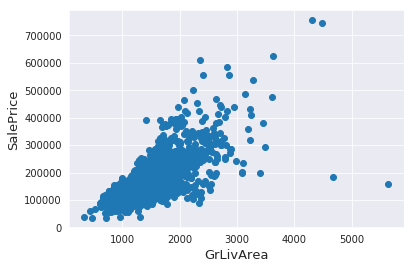

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

実際に見てみると、 SalePrice が小さく、 GrLivArea が大きいところに異常値が見つかります。削除しましょう。

In [7]:
# 異常値の削除
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

## 相関の解析

相関のある特徴量は何でしょうか。

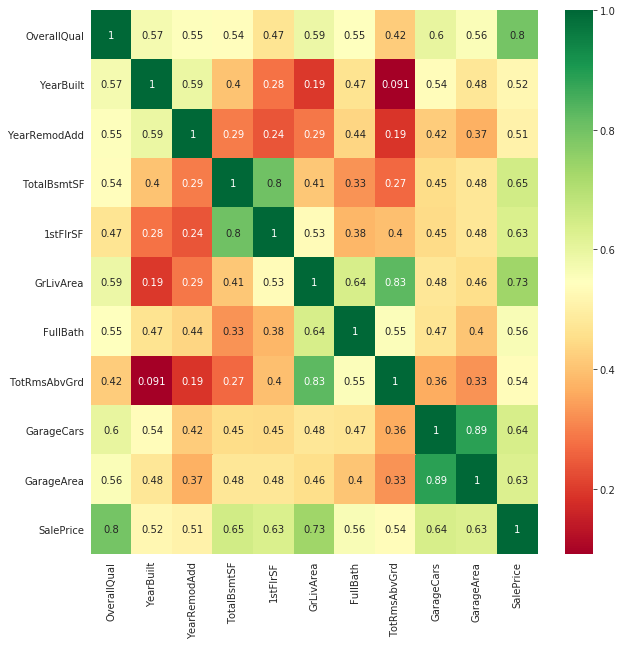

In [8]:
# 一番相関の大きな特徴量
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

* **OverallQual、GrLivArea、TotalBsmtSF** は SalePrice と高い相関を持つと言えます
* **GarageCarsとGarageArea** の間で高い相関が観察されます。これはガレージに収まる車の数は GarageArea に依存しているからでしょう


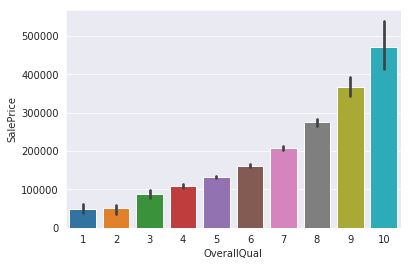

In [9]:
sns.barplot(x=train.OverallQual,y=train.SalePrice)

**'SalePrice' と高い相関を持つ変数の散布図**

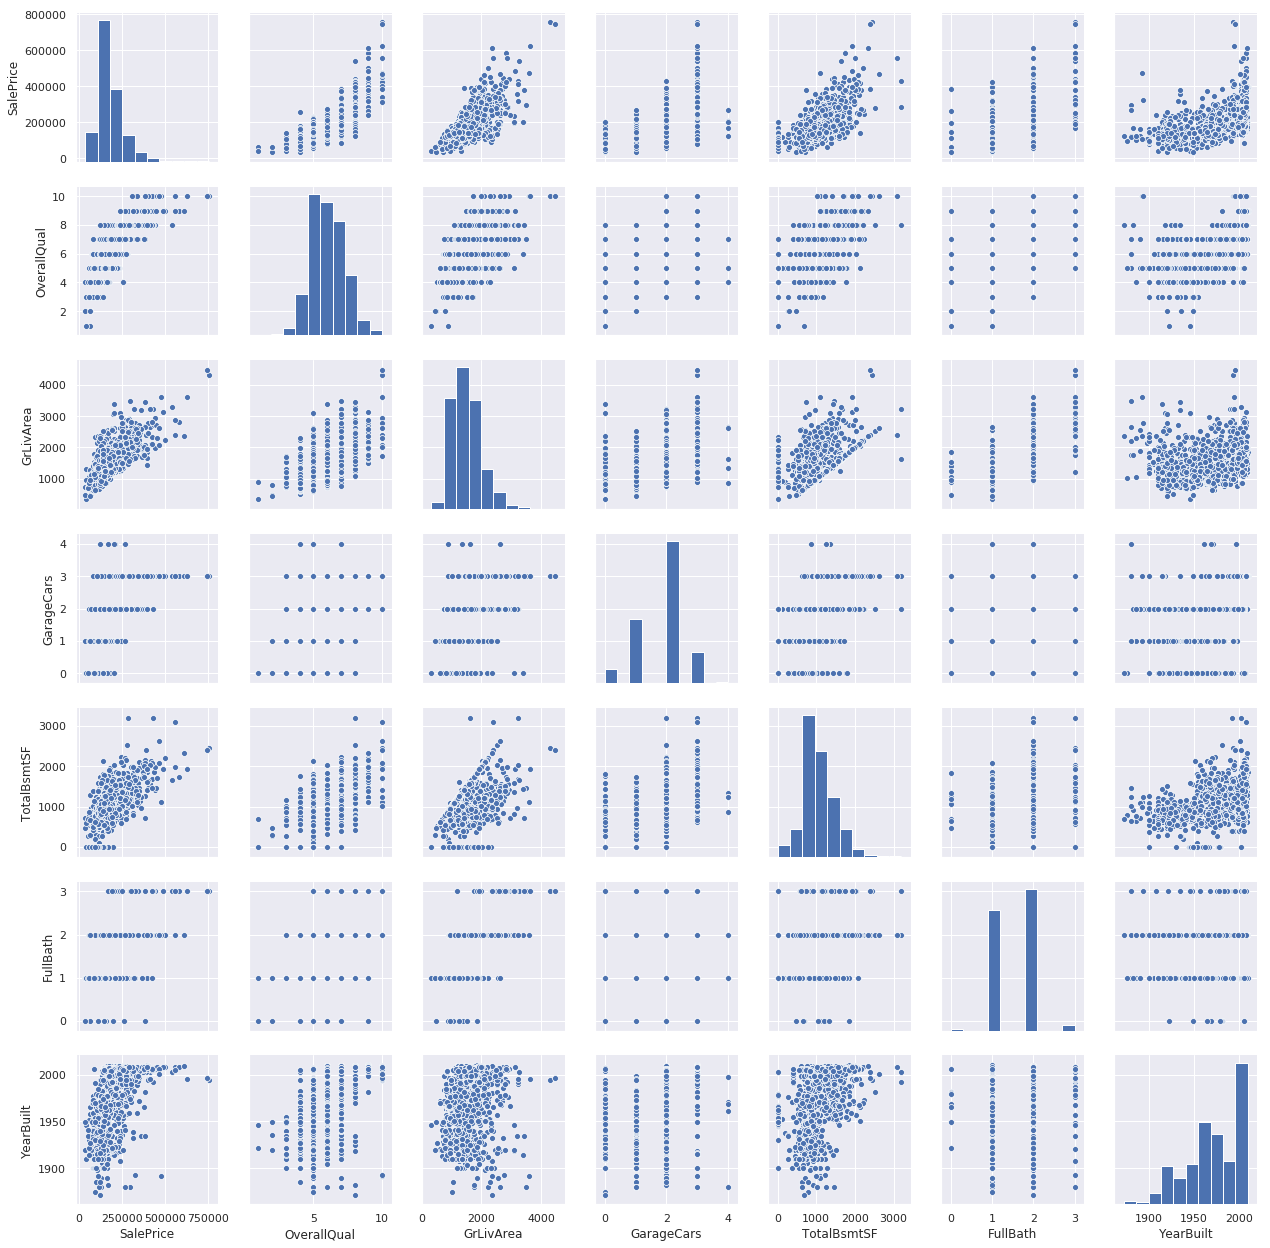

In [10]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

**'TotalBsmtSF' と 'GrLiveArea'** のグラフは興味深い関係性を持つもののひとつです。

まず、境界線になっている線形を示している点群があることがわかります。ほとんどの点はこの直線の下側に収まっていると言えるでしょう。
Basement Area(Bsmt, 地下室の面積のこと) は ground living area（地上面積）と同じ大きさになることはあっても、それよりも大きくなることはまずないからです。

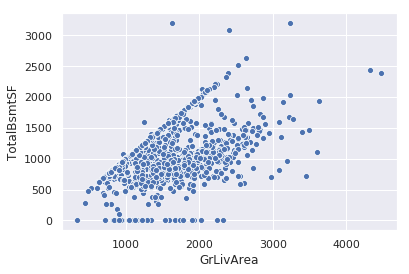

In [11]:
sns.scatterplot(train.GrLivArea,train.TotalBsmtSF)

## 目をつけた変数を変換する

異なる特徴量は、異なるスケールの間でばらつきます。
例えば今回のデータセットなら、 SalePrice は数千から数十万の間の値を取りますが、 YearBlt なら当然数千といったところです。
これらの値同士を比べるなら、重み付きで比較する必要があるということです。


**データの `歪度` を確認してみましょう**
![歪度（Skew）](https://cdn-images-1.medium.com/max/800/1*hxVvqttoCSkUT2_R1zA0Tg.gif)


 mu = 180932.92 and sigma = 79467.79



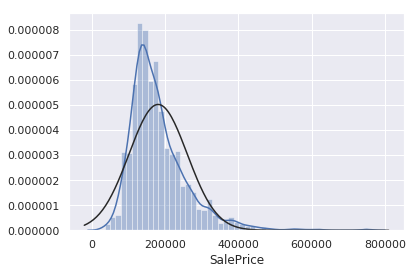

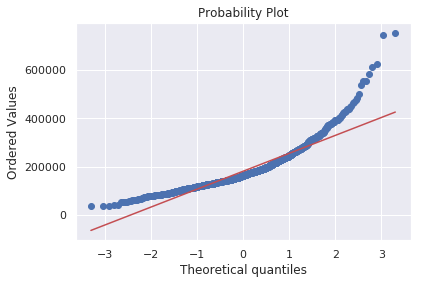

In [12]:
def check_skewness(col):
    sns.distplot(train[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    # 正規分布で fitting する
    (mu, sigma) = norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness('SalePrice')

**この分布関数は正の歪度をもちます**（つまり、左側にピークのずれた、非対称な分布です）。
黒色の正規分布は fitting した結果であり、明らかにこちらのほうが右側にピークがあります。

予測（応答）変数がこのように歪んでいた場合は、 **歪度を矯正しておく** おくことを勧めます。

## では、どうやって矯正すればよいのでしょう？

最も良い方法は、データの **logをとる** ことです。



 mu = 12.02 and sigma = 0.40



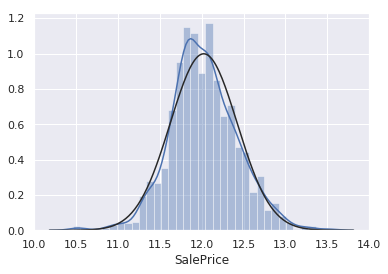

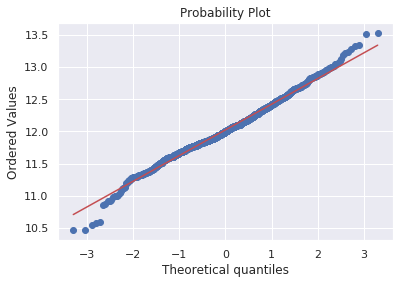

In [13]:
# numpy の log1p (:= log(1+x) ) を適用する
train["SalePrice"] = np.log1p(train["SalePrice"])

check_skewness('SalePrice')

log をとったことでデータの分布が正規分布に見えるようになりました。もちろん完全な正規分布ではないですが、データの歪度を矯正するという意味では十分な効果があるでしょう。

**重要なこと: 応答変数（今回で言えば'SagePrice'）のログを取ったら、特徴量の方も歪んでいるものはログを取るようにしましょう**

# 特徴量の取扱い

**教師データとテストデータの両方に気を配りましょう**

In [14]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("全データの大きさ : {}".format(all_data.shape))

全データの大きさ : (2917, 79)


# 欠損値

In [15]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

Text(0.5, 1.0, 'Percent missing data by feature')

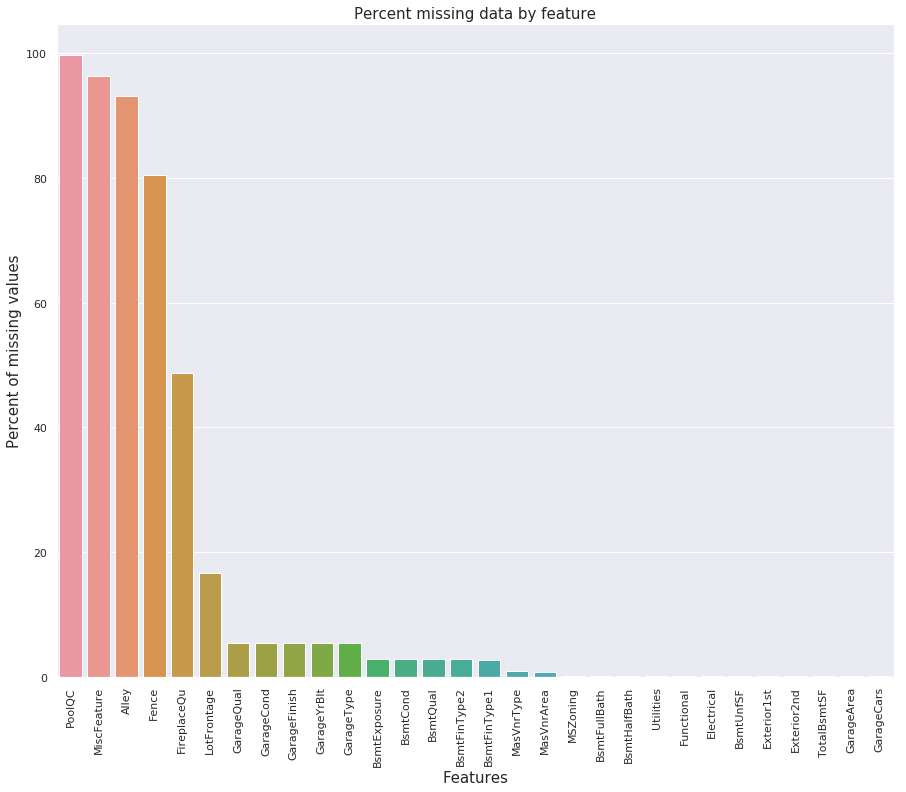

In [16]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [17]:
all_data.PoolQC.loc[all_data.PoolQC.notnull()]

197     Ex
809     Fa
1169    Gd
1181    Ex
1384    Fa
1421    Gd
1972    Ex
2571    Ex
2708    Gd
Name: PoolQC, dtype: object

**GarageType,  GarageFinish, GarageQual,  GarageCond, GarageYrBlt,  GarageArea,  GarageCars は同じくらいの割合で NULL を含んでいます。**

# 欠損値の取扱

PoolQC は NULL の含有率が最も高いですが、ドキュメントによると **NULL はプールが無いことを意味する** とのことです。
ほとんどの家にはプールが無いということです。
そこで、これらの NULL は `None` という文字列で置き換えてしまいましょう。

In [18]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

* **MiscFeature** : ドキュメントによれば NA は "no misc feature" です

In [19]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

* **Alley** : 同じく "no alley access" です

In [20]:
all_data["Alley"] = all_data["Alley"].fillna("None")

* **Fence** : 同上

In [21]:
all_data["Fence"] = all_data["Fence"].fillna("None")

* **FireplaceQu** : 々

In [22]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

* **LotFrontage** : 通りに接している長さは、住宅がある地域ごとに似たような値になるようです。そこで、 'Neighborhood' ごとの中央値で埋めてしまうことにします

In [23]:
# Neighborhood でグルーピングして、グループごとに似たような値であることを確かめます
grouped_df = all_data.groupby('Neighborhood')['LotFrontage']

for key, item in grouped_df:
    print(key,"\n")
    print(grouped_df.get_group(key))
    break

Blmngtn 

219     43.0
229     43.0
385     43.0
443     53.0
465      NaN
558      NaN
596     53.0
638     53.0
789     43.0
850      NaN
981     43.0
1003    43.0
1018    43.0
1022    43.0
1125    53.0
1392    53.0
1413    51.0
1481    43.0
1683    43.0
1982     NaN
1983     NaN
1984    53.0
2318     NaN
2319    53.0
2669    43.0
2670     NaN
2671     NaN
2672    43.0
Name: LotFrontage, dtype: float64


In [24]:
# Neighborhood ごとの中央値で埋める
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

* **GarageType, GarageFinish, GarageQual and GarageCond** : 'None' で埋めます

In [25]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

In [26]:
abc = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt', 'GarageArea', 'GarageCars']
all_data.groupby('GarageType')[abc].count()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageArea,GarageCars
GarageType,,,,,,,
2Types,23,23,23,23,23,23,23
Attchd,1722,1722,1722,1722,1722,1722,1722
Basment,36,36,36,36,36,36,36
BuiltIn,185,185,185,185,185,185,185
CarPort,15,15,15,15,15,15,15
Detchd,779,779,779,779,777,778,778
None,157,157,157,157,0,157,157


* **GarageYrBlt, GarageArea and GarageCars** : 0で置き換えます (ガレージが無いということは0台収まるという意味です）

In [27]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : 0で埋めます。地下室はないという意味です

In [28]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : これらは地下室に関連するカテゴリ変数で、NaN は地下室はないという意味です。

In [29]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

* **MasVnrArea and MasVnrType** : NA は 'masonry veneer' が無いという意味でしょうから、 0 とか None で埋めます

In [30]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

* **MSZoning (The general zoning classification)** : 'RL' は突出してありがちな値なので、これで埋めることにします

In [31]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [32]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

* **Utilities** : このカテゴリ変数はほとんどのデータで同じ値を持っており、役に立たないので drop してしましましょう

In [33]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [34]:
all_data = all_data.drop(['Utilities'], axis=1)

* **Functional** : ドキュメントによれば NA は 'typical' という意味です。これで埋めます。

In [35]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

* **Electrical,KitchenQual, Exterior1st, Exterior2nd, SaleType** : これらのカテゴリ変数は 最瀕値でうめます。

In [36]:
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

* **MSSubClass** : Na はクラス分類されていないという意味なので、'None' で埋めます

In [37]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

## 欠損値が残っていないか確認

In [38]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


**実は、数的特徴量の顔をしたカテゴリ特徴量が混ざっています**

In [39]:
all_data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

**本当はカテゴリを表している数的特徴量は変換しましょう**

見てわかるように、カテゴリの範囲は1から9の数値です（**序数型ではありません**）。 String型に変更しましょう。

カテゴリ型に変換しない場合、モデルは1 <5 <10といったの値を比較するので、これによって余計な影響を受ける場合があります。
今回のモデルではそれを起こす必要はありません。

In [40]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond をカテゴリ変数に変換
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year と month sold をカテゴリ変数に変換
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

## Label Encoding 

このあと使うつもりのもモデルでは、テキスト型のカラムは使えません。
トレーニングの前にデータを更に変換しておきましょう。

カテゴリ型を表すテキストデータをモデルで使える数値型カラムに直すには、 Label Encoder クラスが便利です。

例えば「国」を表す特徴量があったとき、 (India , France, China) を Label Encoder は (0, 1, 2) にエンコードしてくれます。

In [41]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# LabelEncoder をカテゴリ特徴量に適用
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


面積に関連するカラムは住宅価格を推定するのに非常に重要な特徴量のため、合計面積をカラムとして追加しておきます。

In [42]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**歪度の大きい特徴量が無いか確認します。**

In [43]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


## 歪度の大きい特徴量に Box Cox Transformation をかける

現実世界のデータを取り扱うと、しばしば歪度の大きい特徴量に出くわします。

ここで用いる Box-Cox Transformation のような変換テクニックは、データの **分散を安定化** させ、 **正規分布に近づける**ことで、データの関連性の尺度をより良くするために有用です。


Box-Cox Transformation の問題点は、ハイパーパラメータである **lambdaを推定する必要がある**ところです。この値は本来的には実際のデータに基づいて推定するものなので、サンプルデータ以外に対して cross validation を行うときには考慮し直す必要があるでしょう。

### box-cox 変換について

\begin{equation}
boxcox(x) = \begin{cases} 
\displaystyle \frac{x^\lambda - 1}{\lambda} & \lambda \neq 0\\ 
\log x & \lambda = 0\end{cases}
\end{equation}


\begin{equation}
boxcox1p(x) = \begin{cases} 
\displaystyle \frac{(1+x)^\lambda - 1}{\lambda} & \lambda \neq 0\\ 
\log (1+x)& \lambda = 0\end{cases}
\end{equation}



**ta-da point**

原文では上記のように Box-Cox 変換かけていましたが、いまいち理解し難い変換なので、ここは単に log とって進めることにします

In [44]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0  # 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


**カテゴリ変数をダミー変数（数値）化する**

In [45]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

教師データとテストデータを分け直す

In [46]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape

(1458, 220)

## モデルに当てはめてみよう

1. ライブラリのインポート

2. モデルを使ってみる
 - Lasso
 - Ridge
 - ElasticNet
 - Gradient Boosting
 
3. Cross Validation Scoreを確認する
4. 推定結果の平均を取る
5. CSV を sumbit する.
 

In [65]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Cross Validation

Cross Validation は評価値のエラーを計算する単純な方法です。

**KFold( )** は教師データとテストデータをそれぞれ k 個に分けます（分け方はてきとうにランダムにします）。

**cross_val_score( )** が cross-validation スコアを評価します。

In [48]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# Modelling

データセットには大量の特徴量が含まれます。そこで、 Overfitting やノイズを防ぐために正則化を `RobbustScaler()` で施します。
これから使うモデルには正則化パラメータが含まれます。

正則化は各係数の大きさを減らす役目を果たします。

## 線形回帰

原文には無いが比較として追加

In [67]:
lr = make_pipeline(RobustScaler(), LinearRegression())
score = rmsle_cv(lr)
print("Kernel Linear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Linear Regression score: 0.1249 (0.0114)



## Ridge Regression

* パラメータを減らすため、中でも多重共線性を防ぐために使います
* 係数を小さくすることでモデルの複雑性を低減できます
* **L2正則化** を使います

In [68]:
# 普通に Ridge つかうとこう
ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.6, random_state=1))
score = rmsle_cv(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))                

Ridge score: 0.1207 (0.0105)



In [69]:
# 原文ver.
# KernelRidge を使っていて、 RobustScaler していない
# 実験して、原文バージョンのほうがスコアがよいことはわかった
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1161 (0.0072)



## Lasso Regression
LASSO (Least Absolute Shrinkage Selector Operator) は Ridge とよく似ています。

Lasso では alpha というハイパーパラメータで正則化の強度を指定します。
alpha が小さい場合でも、多くのパラメータに対する係数が 0 になることが知られています。
Rigge と違い、 Lasso はパラメータ選択を自動で行う能力のあるモデルであると言えます。

* Lasso では **L1正則化** を使います
* Lasso は特徴量の種類が多く、利用する特徴量を選択したいときに使われます

In [50]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1128 (0.0078)



## Elastic Net Regression

Elastic net は L1正則化 と L2正則化 を組み合わせた手法です。
Ridge と Lasso の混合比もハイパーパラメータによってチューニングできます。

In [51]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1127 (0.0079)



## Gradient Boosting Regression

Refer [here](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d)

説明はまたこんど。

In [52]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



**教師データ全体を使って学習させます**

In [53]:
LassoMd = lasso.fit(train.values,y_train)
ENetMd = ENet.fit(train.values,y_train)
KRRMd = KRR.fit(train.values,y_train)
GBoostMd = GBoost.fit(train.values,y_train)

## 推定結果を平均する

SalePrice はログを取っているので、もとに戻すために `np.expm1()` を使います。
これはつまり `exp(x) - 1` です。

In [54]:
finalMd = (np.expm1(LassoMd.predict(test.values)) + np.expm1(ENetMd.predict(test.values)) + np.expm1(KRRMd.predict(test.values)) + np.expm1(GBoostMd.predict(test.values)) ) / 4
finalMd

array([120062.32775712, 161131.62642951, 184503.74816073, ...,
       171869.95742163, 117060.87347719, 220809.75934448])

## Submission

In [55]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = finalMd
sub.to_csv('submission.csv',index=False)